
# Observations / questions

- HyperSpy: Hard to figure out what is wrong

- Figure out good parameters?

- Does better fit mean better quantification? Better analysis?

- Ga K alpha lines are one, not two

- How many use EDS SEM quantification? HyperSpy only does TEM

- How important is +- 5% error in calibration?



# Problems

- I pretend I have thin film TEM sample
- HyperSpy is large, complex, and not well documented
    - Legend om model plot
    - Hover info
    - Understanding how the background is fitted
- k-factors
    - Theoretically estimated
    - k-ratios?


# Further plan

- Write a report
- Organize the code, if it might be valuable for others
- Look more into factorless quantification
- More data

In [1]:
import hyperspy.api as hs
from utils.get_raw_data import locate_raw_data


In [40]:
%matplotlib qt

In [2]:
emsa = locate_raw_data()


In [3]:
hs.material.elements.Mo.Atomic_properties.Xray_lines.as_dictionary()

{'Lb1': {'weight': 0.32736, 'energy (keV)': 2.3948},
 'Kb': {'weight': 0.15, 'energy (keV)': 19.6072},
 'Ka': {'weight': 1.0, 'energy (keV)': 17.4793},
 'Lb2': {'weight': 0.04509, 'energy (keV)': 2.5184},
 'La': {'weight': 1.0, 'energy (keV)': 2.2932},
 'Ln': {'weight': 0.0128, 'energy (keV)': 2.1205},
 'Ll': {'weight': 0.0415, 'energy (keV)': 2.0156},
 'Lb3': {'weight': 0.06299, 'energy (keV)': 2.4732},
 'Lg3': {'weight': 0.0105, 'energy (keV)': 2.8307},
 'Lg1': {'weight': 0.01335, 'energy (keV)': 2.6233}}

In [4]:
hs.eds.get_xray_lines_near_energy(17.5)

['Mo_Ka', 'U_Lb3']

<class 'hyperspy._signals.eds_tem.EDSTEMSpectrum'>


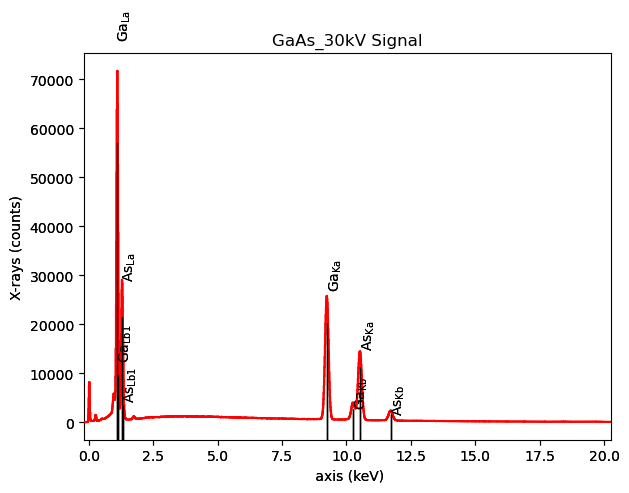

In [23]:
s_AZ = hs.load(emsa[7], signal_type="EDS_TEM")
print(type(s_AZ))
s_AZ.add_elements(['As', 'Ga'])
s_AZ.plot(xray_lines=True)

In [24]:
# s_AZ.metadata

In [25]:
# Line_width is the distance from the x-ray line (in FWHM) the the background window is taken [left, right] allowing different distances for the two directions.
bw = s_AZ.estimate_background_windows(windows_width=2)
iw =  s_AZ.estimate_integration_windows(windows_width=2)

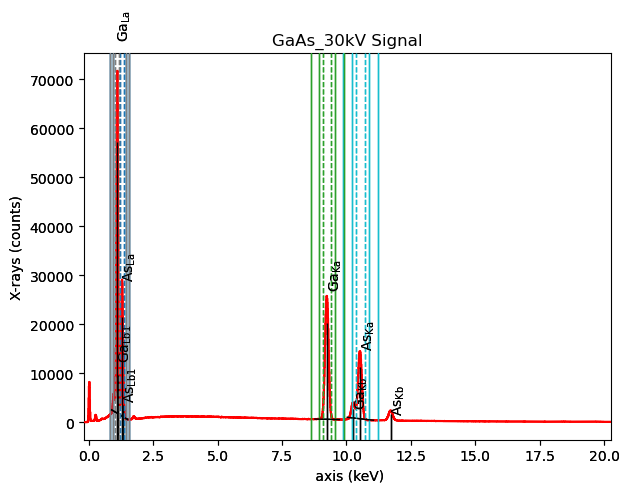

In [26]:
s_AZ.plot(xray_lines=True, background_windows=bw, integration_windows=iw)

In [27]:
s_AZ_intensities = s_AZ.get_lines_intensity(background_windows=bw, integration_windows=iw)
k_factors = [4.191, 3.268] # As, Ga
quant = s_AZ.quantification(s_AZ_intensities, 'CL', factors=k_factors)
print(f'As: {quant[0].data[0]:.2f} %, Ga: {quant[1].data[0]:.2f} %')

[########################################] | 100% Completed | 116.88 ms
As: 56.95 %, Ga: 43.05 %


In [28]:
quant[0].metadata

├── Acquisition_instrument
│   └── TEM
│       ├── Detector
│       │   └── EDS
│       │       ├── azimuth_angle = 0.0
│       │       ├── elevation_angle = 35.0
│       │       ├── energy_resolution_MnKa = 130.0
│       │       ├── live_time = 120.0
│       │       └── real_time = 173.751037598
│       ├── Stage
│       │   └── tilt_alpha = 0.0
│       └── beam_energy = 30.0
├── General
│   ├── FileIO
│   │   └── 0
│   │       ├── hyperspy_version = 1.7.1
│   │       ├── io_plugin = hyperspy.io_plugins.msa
│   │       ├── operation = load
│   │       └── timestamp = 2022-12-05T15:17:15.358882+01:00
│   ├── date = 2022-09-06
│   ├── original_filename = GaAs_30kV.emsa
│   ├── time = 17:02:00
│   └── title = atomic percent of As
├── Sample
│   ├── elements = ['As']
│   └── xray_lines = ['As_Ka']
└── Signal
    ├── quantity = X-rays (counts)
    └── signal_type = EDS_TEM

In [29]:
quant[0].metadata.Sample.xray_lines

['As_Ka']

In [30]:
s_AZ_intensities

[<BaseSignal, title: X-ray line intensity of GaAs_30kV: As_Ka at 10.54 keV, dimensions: (1|)>,
 <BaseSignal, title: X-ray line intensity of GaAs_30kV: Ga_Ka at 9.25 keV, dimensions: (1|)>]

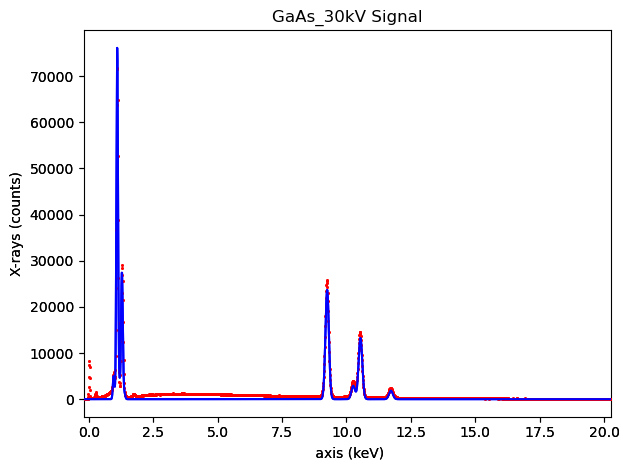

In [31]:
# model fit
m = s_AZ.create_model()
m.add_family_lines(['As_Ka', 'Ga_Ka'])
m.plot()


In [32]:
m.fit();
# m.print_current_values()

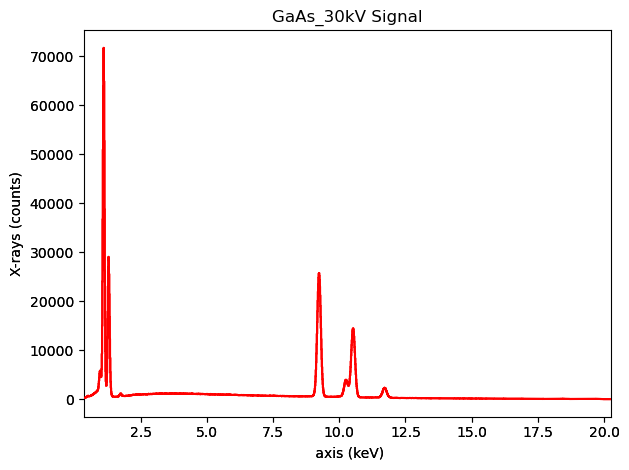

In [33]:
zero_peak_channel = 55
s_GaAs = s_AZ.isig[zero_peak_channel:]
s_GaAs.plot()

   # |      Attribute Name |      Component Name |      Component Type
---- | ------------------- | ------------------- | -------------------
   0 |               As_Ka |               As_Ka |            Gaussian
   1 |               As_Kb |               As_Kb |            Gaussian
   2 |               As_La |               As_La |            Gaussian
   3 |              As_Lb1 |              As_Lb1 |            Gaussian
   4 |               As_Ln |               As_Ln |            Gaussian
   5 |               As_Ll |               As_Ll |            Gaussian
   6 |              As_Lb3 |              As_Lb3 |            Gaussian
   7 |               Ga_Ka |               Ga_Ka |            Gaussian
   8 |               Ga_Kb |               Ga_Kb |            Gaussian
   9 |               Ga_La |               Ga_La |            Gaussian
  10 |              Ga_Lb1 |              Ga_Lb1 |            Gaussian
  11 |               Ga_Ln |               Ga_Ln |            Gaussian
  12 |

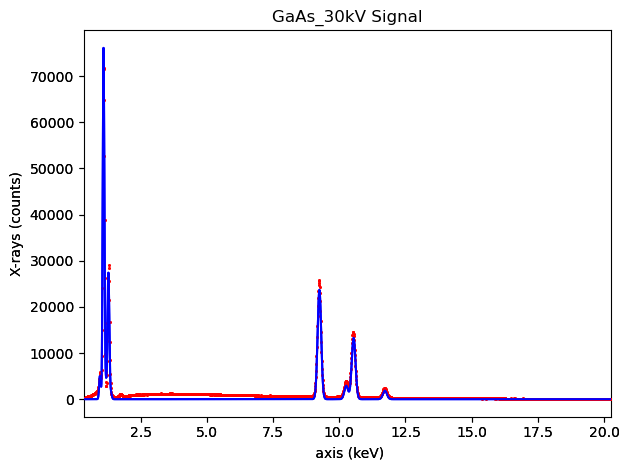

In [34]:
m2 = s_GaAs.create_model(auto_add_lines=True, auto_background=False)
# removing the zero peak
m2.add_polynomial_background(order=12)
m2.plot()
m2.components

In [35]:
# check if m and m2 are the same
# they are, except for the background component
# for c in range(len(m.as_dictionary()['components'])):
#     print(m.as_dictionary()['components'][c]['name'], round(m.as_dictionary()['components'][c]['parameters'][0]['value']), round(m2.as_dictionary()['components'][c]['parameters'][0]['value']) )

In [36]:
# m2.print_current_values()

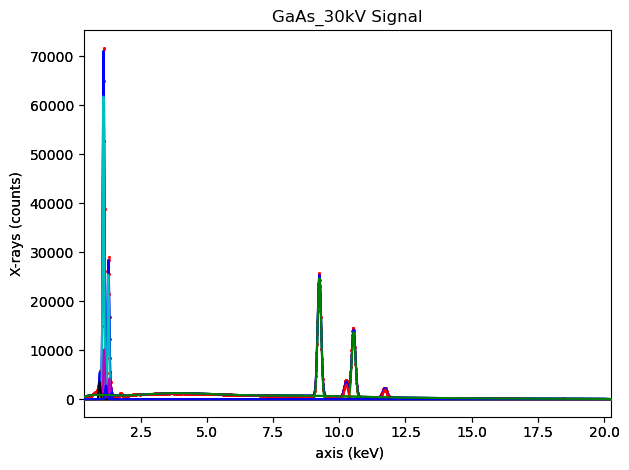

In [37]:
m2.fit()
# m2.fit_background()
m2.plot(True)

In [38]:
# get intensities from m and m2
m_i = m.get_lines_intensity()
m_i[::2]

[<BaseSignal, title: Intensity of As_Ka at 10.54 keV from GaAs_30kV, dimensions: (1|)>,
 <BaseSignal, title: Intensity of Ga_Ka at 9.25 keV from GaAs_30kV, dimensions: (1|)>]

In [39]:
quant_m = s_AZ.quantification(m_i[::2], 'CL', factors=k_factors)
print(f'As: {quant_m[0].data[0]:.2f} %, Ga: {quant_m[1].data[0]:.2f} %')

[########################################] | 100% Completed | 150.81 ms
As: 41.31 %, Ga: 58.69 %


In [40]:
m2.axes_manager

Signal axis name,size,,offset,scale,units
,1993,,0.35000000000000003,0.01,keV


In [41]:
m2.calibrate_energy_axis(calibrate='scale')
m2.calibrate_energy_axis(calibrate='offset')
m2.axes_manager

Signal axis name,size,,offset,scale,units
,1993,,0.3448256209751314,0.010013359528487229,keV


In [42]:
quant_m = s_AZ.quantification(m_i[::2], 'CL', factors=k_factors)
print(f'As: {quant_m[0].data[0]:.3f} %, Ga: {quant_m[1].data[0]:.3f} %')

[########################################] | 100% Completed | 118.38 ms
As: 41.314 %, Ga: 58.686 %


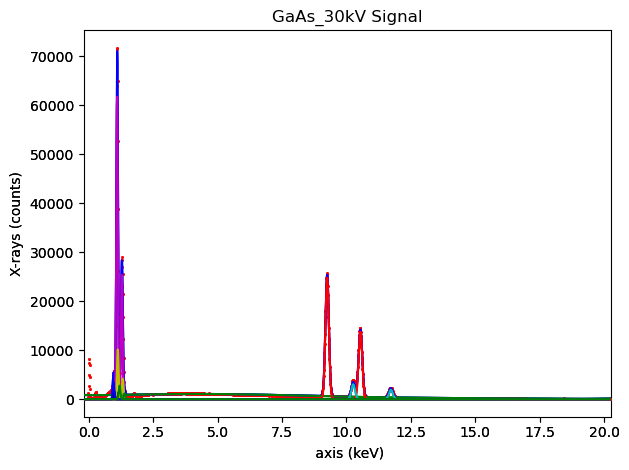

In [43]:
m.plot(True)

In [44]:
m2_i = m2.get_lines_intensity()
quant_m2 = s_GaAs.quantification(m2_i[::2], 'CL', factors=k_factors)
print(f'As: {quant_m2[0].data[0]:.2f} %, Ga: {quant_m2[1].data[0]:.2f} %')

[########################################] | 100% Completed | 117.79 ms
As: 41.49 %, Ga: 58.51 %


In [36]:

dispersion_GaAs = 0.010030009470672611
offset_GaAs = 21.1267053826366
offset_keV_GaAs = offset_GaAs * dispersion_GaAs

dispersion_mo = 0.010039892338014457
offset_mo = 21.076486916545974
offset_keV_mo = dispersion_mo * offset_mo

# NB! k-factors are sorted alfabetically, so As first, then Ga.
# it is the same order as the x-ray lines in the family_lines list

# make function which takes a file name and returns the quantification results with three different calibrations
def quant_three_ways(filename, factors, s_GaAs_dispersion=dispersion_GaAs, s_GaAs_offset=offset_keV_GaAs, elements=['As', 'Ga'], family_lines=['As_Ka', 'Ga_Ka'], window_width=3, line_width=[2.0, 2.0], plot=False):
    bg_order = 12
    s_AZ = hs.load(filename, signal_type="EDS_TEM")
    s_AZ.add_elements(elements)
    m1 = s_AZ.create_model()
    m1.add_family_lines(family_lines)
    # m1.add_polynomial_background(order=bg_order)
    # m1.fit_background()
    m1.fit(bounded=True)
    bw1 = s_AZ.estimate_background_windows(line_width=line_width)
    iw1 =  s_AZ.estimate_integration_windows(windows_width=window_width)
    s_AZ_intensities = s_AZ.get_lines_intensity(background_windows=bw1, integration_windows=iw1)
    quant_AZ = s_AZ.quantification(s_AZ_intensities, 'CL', factors=factors)


    print(s_AZ.metadata.Acquisition_instrument.TEM.beam_energy, 'Vacc')
    
    s_GaAs = hs.load(filename, signal_type="EDS_TEM")
    s_GaAs.add_elements(elements)
    s_GaAs.axes_manager[-1].name = 'E'
    s_GaAs.axes_manager['E'].units = 'keV'
    s_GaAs.axes_manager['E'].scale = s_GaAs_dispersion
    s_GaAs.axes_manager['E'].offset = -s_GaAs_offset
    m2 = s_GaAs.create_model()
    m2.add_family_lines(family_lines)
    # m2.add_polynomial_background(order=bg_order)
    # m2.fit_background()
    m2.fit(bounded=True)
    bw2 = s_GaAs.estimate_background_windows(line_width=line_width)
    iw2 =  s_GaAs.estimate_integration_windows(windows_width=window_width)
    s_GaAs_intensities = s_GaAs.get_lines_intensity(background_windows=bw2, integration_windows=iw2)
    quant_GaAs = s_GaAs.quantification(s_GaAs_intensities, 'CL', factors=factors)
    
    s_HS = hs.load(filename, signal_type="EDS_TEM")
    s_HS.add_elements(elements)
    # m3 = s_HS.create_model(auto_background=False)
    m3 = s_HS.create_model()
    m3.add_family_lines(family_lines)
    # m3.add_polynomial_background(order=bg_order)
    # m3.fit_background()
    m3.fit()
    m3.calibrate_energy_axis(calibrate='scale')
    m3.calibrate_energy_axis(calibrate='offset')
    bw3 = s_HS.estimate_background_windows(line_width=line_width)
    iw3 =  s_HS.estimate_integration_windows(windows_width=window_width)
    s_HS_intensities = s_HS.get_lines_intensity(background_windows=bw3, integration_windows=iw3)
    quant_HS = s_HS.quantification(s_HS_intensities, 'CL', factors=factors)

    if plot:
        m3.plot(True, legend='auto')
        # hs.plot.plot_spectra([s_AZ,s_GaAs,s_HS], legend='auto')

    # return the quantification results, and the three signals
    # swapped the order here
    return [quant_AZ, quant_HS, quant_GaAs], [s_AZ, s_HS, s_GaAs]

# pretty print of quantification results
def print_quant_table(title, quant_list, elements=['As', 'Ga']):
    print(f"\n{title}")
    print(f"\n{'':<11}| " + f"{'s_AZ':<10}| " + f"{'s_HS':<10}| " + f"{'s_GaAs':<10}")
    for q in range(len(elements)):
        print(f"{elements[q]:<11}| " + f"{quant_list[0][q].data[0]:<10.2f}| " + f"{quant_list[1][q].data[0]:<10.2f}| " + f"{quant_list[2][q].data[0]:<10.2f}")

def print_dispersion_offset(s_list):
    print(f"\n{'':<11}| " + f"{'s_AZ':<10}| " + f"{'s_HS':<10}| " + f"{'s_GaAs':<10}")
    print(f"{'dispersion':<11}| " + f"{s_list[0].axes_manager[-1].scale:<10.6f}| " + f"{s_list[1].axes_manager[-1].scale:<10.6f}| " + f"{s_list[2].axes_manager[-1].scale:<10.6f}")
    print(f"{'offset':<11}| " + f"{s_list[0].axes_manager[-1].offset:<10.6f}| " + f"{s_list[1].axes_manager[-1].offset:<10.6f}| " + f"{s_list[2].axes_manager[-1].offset:<10.6f}")



In [13]:
# s_HS = hs.load(emsa[7], signal_type="EDS_TEM")
# s_HS.add_elements(elements)
# # m3 = s_HS.create_model(auto_background=False)
# m3 = s_HS.create_model()
# m3.add_family_lines(family_lines)
# # m3.add_polynomial_background(order=bg_order)
# # m3.fit_background()
# m3.fit()
# m3.calibrate_energy_axis(calibrate='scale')
# m3.calibrate_energy_axis(calibrate='offset')
# # bw3 = s_HS.estimate_background_windows(line_width=line_width)
# # iw3 =  s_HS.estimate_integration_windows(windows_width=window_width)
# # s_HS_intensities = s_HS.get_lines_intensity(background_windows=bw3, integration_windows=iw3)
# # quant3 = s_HS.quantification(s_HS_intensities, 'CL', factors=factors)

In [14]:
# for key in m3.active_components:
    # print(key.print_current_values())

In [15]:
# m3.plot?

In [37]:
factors5 = [1.210, 1.086] # 5kV k-factors, As then Ga on the L-series
family_lines=['Ga_La', 'As_La']
quant_list5, s_list5 = quant_three_ways(emsa[4], factors5, family_lines=family_lines, plot=False)
print_quant_table("Quantification results 5kV L-series", quant_list5)
# print_dispersion_offset(s_list5)

[########################################] | 100% Completed | 114.32 ms
5.0 Vacc
[########################################] | 100% Completed | 113.22 ms
[########################################] | 100% Completed | 109.47 ms

Quantification results 5kV L-series

           | s_AZ      | s_HS      | s_GaAs    
As         | 44.81     | 44.29     | 44.19     
Ga         | 55.19     | 55.71     | 55.81     


In [10]:
emsa[5]

WindowsPath('C:/Users/Brynjar/Documents/Masteroppgave/2022-09-06_EDS-Apreo/exports/GaAs_10kV.emsa')

In [19]:
factors10 = [1.310, 1.223] # 10kV k-factors, Ga and As L-series
family_lines=['As_La', 'Ga_La']
quant_list10, s_list10 = quant_three_ways(emsa[5], factors10, family_lines=family_lines, plot=False)
print_quant_table("Quantification results 10kV L-series", quant_list10)
# print_dispersion_offset(s_list10)

[########################################] | 100% Completed | 118.38 ms
10.0 Vacc
[########################################] | 100% Completed | 108.71 ms
[########################################] | 100% Completed | 114.78 ms

Quantification results 10kV L-series

           | s1        | s2        | s3        
As         | 100.00    | 100.00    | 100.00    
Ga         | 0.00      | 0.00      | 0.00      


In [38]:
factors15 = [1.331, 1.259] # 15kV k-factors, Ga and As L-series
family_lines=['Ga_La', 'As_La']
quant_list15, s_list15 = quant_three_ways(emsa[6], factors15)
print_quant_table("Quantification results 15kV L-series", quant_list15)
# print_dispersion_offset(s_list15)

[########################################] | 100% Completed | 104.27 ms
15.05 Vacc
[########################################] | 100% Completed | 117.05 ms
[########################################] | 100% Completed | 115.26 ms

Quantification results 15kV L-series

           | s_AZ      | s_HS      | s_GaAs    
As         | 5.23      | 4.39      | 5.87      
Ga         | 94.77     | 95.61     | 94.13     


In [41]:
# factors30 = [4.191, 1.986, 3.268, 1.505] # 30kV k-factors, Ga and As K-series
# family_lines=['As_Ka', 'C_Ka', 'Ga_Ka',  'O_Ka']
# elements=['As', 'C', 'Ga', 'O']
factors30 = [4.191, 3.268] # 30kV k-factors, Ga and As K-series
family_lines=['As_Ka', 'Ga_Ka']
elements=['As', 'Ga']
quant_list30, s_list30 = quant_three_ways(emsa[7], factors30, family_lines=family_lines, elements=elements, plot=True)
print_quant_table("Quantification results 30kV", quant_list30, elements)
print_dispersion_offset(s_list30)


[########################################] | 100% Completed | 115.65 ms
30.0 Vacc
[########################################] | 100% Completed | 107.25 ms
[########################################] | 100% Completed | 112.85 ms

Quantification results 30kV

           | s_AZ      | s_HS      | s_GaAs    
As         | 56.25     | 57.14     | 59.02     
Ga         | 43.75     | 42.86     | 40.98     

           | s_AZ      | s_HS      | s_GaAs    
dispersion | 0.010000  | 0.010003  | 0.010030  
offset     | -0.200000 | -0.203917 | -0.211901 


In [23]:
# print huge table
def print_all_quants(Vaccs, quants, elements, k_factors):
    names = ['AZ', 'GaAs', 'HS']
    # print('Weight percent results\n')
    for i in range(len(Vaccs)):
        lines = ''
        for line in quants[i][0]:
            lines += f" {line.metadata.Sample.xray_lines[0]}"
        # lines = f"({quants[i][0][0].metadata.Sample.xray_lines[0]}, {quants[i][0][1].metadata.Sample.xray_lines[0]})"
        print(f"\n{Vaccs[i]} kV ({lines} )  k-factors: {k_factors[i]}  \n{'-'*32}")
        print(f"{'':<8}| " + f"{elements[0]:<10}| " + f"{elements[1]:<10}")
        for j in range(len(names)):
            print(f"{names[j]:<8}| " + f"{quants[i][j][0].data[0]:<10.2f}| " + f"{quants[i][j][1].data[0]:<10.2f}")
        


In [57]:
Vaccs = [5, 10, 15, 30]
quants = [quant_list5, quant_list10, quant_list15, quant_list30]
k_factors = [factors5, factors10, factors15, factors30]
elements = ['As', 'Ga']
dispersions = [s_list5, s_list10, s_list15, s_list30]
methods = ['AZ', 'HS', 'GaAs']
print_all_quants(Vaccs, quants, elements, k_factors)


5 kV ( As_La Ga_La )  k-factors: [1.21, 1.086]  
--------------------------------
        | As        | Ga        
AZ      | 44.81     | 55.19     
GaAs    | 44.29     | 55.71     
HS      | 44.19     | 55.81     

10 kV ( As_La Ga_La )  k-factors: [1.31, 1.223]  
--------------------------------
        | As        | Ga        
AZ      | 100.00    | 0.00      
GaAs    | 100.00    | 0.00      
HS      | 100.00    | 0.00      

15 kV ( As_La Ga_La )  k-factors: [1.331, 1.259]  
--------------------------------
        | As        | Ga        
AZ      | 5.23      | 94.77     
GaAs    | 4.39      | 95.61     
HS      | 5.87      | 94.13     

30 kV ( As_Ka Ga_Ka )  k-factors: [4.191, 3.268]  
--------------------------------
        | As        | Ga        
AZ      | 56.25     | 43.75     
GaAs    | 57.14     | 42.86     
HS      | 59.02     | 40.98     


In [32]:
quants[0][0][0].metadata.Sample.elements

['As']

In [66]:
# print huge table
def print_all_quants_GaAs(Vaccs, quants, elements, k_factors, methods):
    names = ['AZ', 'GaAs', 'HS']
    # header = Vacc & Element & line & AZ & HS & GaAs
    print(f'{"Vacc":<10} & {"Element":<10} & {"Line":<10} & {"AZ":<10} & {"HS":<10} & {"GaAs":<10} \\\\')
    for v in range(len(Vaccs)): # 4 kV
        Vacc = Vaccs[v]
        # for m in range(len(quants[v])): # three quantification methods
        #     method = methods[m]
            # for e in range(len(quants[v][m])): # two elements
            #     row = ''
            #     az = quants[v][m][e].data[0]
            #     hs_quant 
            
        e1 = quants[v][0][0].metadata.Sample.elements[0]
        l1 = quants[v][0][0].metadata.Sample.xray_lines[0]
        e2 = quants[v][0][1].metadata.Sample.elements[0]
        l2 = quants[v][0][1].metadata.Sample.xray_lines[0]
        print(f'{Vacc:<10} & {e1:<10} & {l1:<10} & {quants[v][0][0].data[0]:<10.2f} & {quants[v][1][0].data[0]:<10.2f} & {quants[v][2][0].data[0]:<10.2f} \\\\')
        print(f'{Vacc:<10} & {e2:<10} & {l2:<10} & {quants[v][0][1].data[0]:<10.2f} & {quants[v][1][1].data[0]:<10.2f} & {quants[v][2][1].data[0]:<10.2f} \\\\')

print_all_quants_GaAs(Vaccs, quants, elements, k_factors, methods)

Vacc       & Element    & Line       & AZ         & HS         & GaAs       \\
5          & As         & As_La      & 44.81      & 44.29      & 44.19      \\
5          & Ga         & Ga_La      & 55.19      & 55.71      & 55.81      \\
10         & As         & As_La      & 100.00     & 100.00     & 100.00     \\
10         & Ga         & Ga_La      & 0.00       & 0.00       & 0.00       \\
15         & As         & As_La      & 5.23       & 4.39       & 5.87       \\
15         & Ga         & Ga_La      & 94.77      & 95.61      & 94.13      \\
30         & As         & As_Ka      & 56.25      & 57.14      & 59.02      \\
30         & Ga         & Ga_Ka      & 43.75      & 42.86      & 40.98      \\
